Fruchterman-Reingold Python Implementation from https://github.com/EmmanuelMess/Fruchterman-Reingold-Grafos-TrabajoFinal

In [1]:
import argparse
import math

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
from numpy import random

#Numba takes it from 1min 36s to ~40s
from numba import njit, prange, vectorize


class AnimatedScatter(object):
    def __init__(self, stream, size):
        self.stream = stream
        self.size = size

        self.fig, self.ax = plt.subplots()
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=5,
                                          init_func=self.setup_plot, blit=True)

    def setup_plot(self):
        points, lines = next(self.stream)
        x, y = points

        self.scat = self.ax.scatter(x, y, color='00')
        self.plots = []

        for x, y in lines:
            self.plots.append(self.ax.plot(x, y, color='00')[0])

        self.ax.axis([0, self.size, 0, self.size])#TODO pass size
        return [self.scat] + self.plots

    def update(self, i):
        plottableOrNone = next(self.stream)
        if plottableOrNone is None:
            self.ani.event_source.stop()
            return [self.scat] + self.plots

        points, lines = plottableOrNone
        x, y = points

        self.scat.set_offsets(np.c_[np.asarray(x), np.asarray(y)])

        for i in range(len(lines)):
            x, y = lines[i]
            self.plots[i].set_data(x, y)

        return [self.scat] + self.plots



def fast_euclidean_distance(vector):
    """
    Para escalares math.sqrt es mas rapido que np.math.sqrt
    """
    return math.sqrt(vector[0]*vector[0] + vector[1]*vector[1])


class LayoutGraph:

    def __init__(self, tamano: float, grafo, iters, refresh, c1, c2, initial_t, update_temp, verbose=False,
                 limit_repulsion=False):
        """
        Parámetros:
        tamano: tamaño de uno de los lados del cuadrado que limita la representacion
        grafo: grafo en formato lista
        iters: cantidad de iteraciones a realizar
        refresh: cada cuántas iteraciones graficar. Si su valor es cero, entonces debe graficarse solo al final.
        c1: constante de attracion
        c2: constante de repulsion
        initial_t: constante inicial de temperatura
        update_temp: constante de actualizacion de la temperatura
        verbose: si está encendido, activa los comentarios
        limit_repulsion: limita la distancia de repulsion, hace que ande mas rapido
        """

        # Guardo el grafo
        self.grafo = grafo
        (V, E) = grafo
        self.edgesByIndex = [(V.index(a), V.index(b)) for (a, b) in E]

        # Guardo opciones
        self.iters = iters
        self.verbose = verbose
        self.size = tamano
        self.refresh = refresh
        self.c1 = c1
        self.c2 = c2
        self.initial_t = initial_t
        self.update_temp = update_temp
        self.limit_repulsion = limit_repulsion

    def layout(self):
        """
        Aplica el algoritmo de Fruchtermann-Reingold para obtener (y mostrar)
        un layout
        """
        V, E = self.grafo

        self.k1 = self.c1 * np.sqrt(self.size * self.size / len(V))
        self.k2 = self.c2 * np.sqrt(self.size * self.size / len(V))

        self._randomize_positions()
        self._initialize_temperature()

        for k in range(self.iters):
            self._log(lambda: "Inicio iteracion {}".format(k))

            self._step()

            self._log(lambda: "Fin iteracion {}".format(k))
            self._log(lambda: "Posiciones " + str(self.posiciones.tolist()))

            if self.refresh > 0 and (k % self.refresh == 0 or k == 0):
                yield self._displayable()

        if self.refresh >= 0:
            yield self._displayable()

        yield None

    def _randomize_positions(self):
        V, E = self.grafo
        size = self.size #float tamaño del espacio

        self.posiciones = np.random.default_rng().uniform(0, size, (len(V), 2))

    def _step(self):
        self._initialize_accumulators()
        self._compute_attractions()
        self._compute_repulsions()
        self._compute_gravity()
        self._separate_overlapping_vertex()
        self._update_positions()
        self._update_temperature()

    def _displayable(self):
        V, E = self.grafo
        points = (self.posiciones[:, 0], self.posiciones[:, 1]) #, color='00')

        lines = []
        for a, b in E:
            x = [self.posiciones[V.index(a), 0], self.posiciones[V.index(b), 0]]
            y = [self.posiciones[V.index(a), 1], self.posiciones[V.index(b), 1]]
            lines.append((x, y))

        return points, lines

    def _initialize_temperature(self):
        self.temperature = self.initial_t

    def _initialize_accumulators(self):
        V, E = self.grafo
        self.accumulator = np.zeros((len(V), 2), dtype=float)

    def _compute_attractions(self):
        LayoutGraph.optimized_compute_attractions(self.edgesByIndex, self.posiciones, self.k1, self.accumulator)
        
    def _force_attraction(self, x):
        return x * x / self.k1
        
    @staticmethod
    @njit
    def optimized_compute_attractions(edgesByIndex, posiciones, k1, accumulator):
        for ii in prange(len(edgesByIndex)):
            (i, j) = edgesByIndex[ii]

            vector = posiciones[i] - posiciones[j]
            distance = np.linalg.norm(vector)
            delta_attraction = distance * distance / k1
            force = delta_attraction * (vector / distance)
            accumulator[i] -= force
            accumulator[j] += force

            #self._log(lambda: "[A] Sobre ({},{}) se aplica |({:.2f},{:.2f})|={:.2f}"
            #          .format(a, b, force[0], force[1], fast_euclidean_distance(force)))

    def _compute_repulsions(self):
        LayoutGraph.optimized_compute_repulsions(self.grafo, self.posiciones, self.limit_repulsion, self.k2, self.accumulator)

    @staticmethod
    @njit
    def optimized_compute_repulsions(grafo, posiciones, limit_repulsion, k2, accumulator):
        V, E = grafo
        for i in prange(len(V)):
            for j in prange(len(V)):
                if i == j:
                    continue

                vector = posiciones[i] - posiciones[j]
                distance = np.linalg.norm(vector)

                if limit_repulsion and distance > 2 * k2:
                    continue

                delta_repulsion = -k2 * k2 / distance
                force = delta_repulsion * (vector / distance)
                accumulator[i] -= force
                accumulator[j] += force

                #self._log(lambda: "[R] Sobre ({},{}) se aplica |({:.2f},{:.2f})|={:.2f}"
                #          .format(V[i], V[j], force[0], force[1], fast_euclidean_distance(force)))

    def _compute_gravity(self):
        gravity_origin = np.ones(2, dtype=float) * self.size / 2

        V, E = self.grafo
        for i in range(len(V)):
            vector = gravity_origin - self.posiciones[i]
            distance = fast_euclidean_distance(vector)
            delta_attraction = self._force_gravity(distance)
            force = delta_attraction * (vector / distance)
            self.accumulator[i] += force

            self._log(lambda: "[G] Sobre {} se aplica ({:.2f},{:.2f})".format(V[i], force[0], force[1]))

    def _force_gravity(self, x):
        return 0.1 * self._force_attraction(x)

    def _separate_overlapping_vertex(self):
        if not np.isnan(self.accumulator).any():
            return

        # Esto solo se ejecuta si alguna division dio nan,
        # es decir, si la distancia fue 0 en alguna cuenta
        eps = 0.005

        for i in range(self.accumulator.shape[0]):
            if np.isnan(self.accumulator[i]).any():
                #Genera un vector normal en una direccion al azar,
                # pero todas las direcciones tienen la misma probabilidad
                small_force = np.random.normal(0, 1, 2)
                small_force = fast_euclidean_distance(small_force)
                small_force *= eps
                self.accumulator[i] = small_force

    def _update_positions(self):
        V, E = self.grafo
        for i in range(len(V)):
            distance = fast_euclidean_distance(self.accumulator[i])

            if distance > self.temperature:
                self.accumulator[i] /= distance
                self.accumulator[i] *= self.temperature

            self.posiciones[i] += self.accumulator[i]

        self.posiciones = np.clip(self.posiciones, 0, self.size)

    def _update_temperature(self):
        self.temperature *= self.update_temp

        self._log(lambda: "Temperatura ahora: {:.2f}".format(self.temperature))

    def _log(self, msg:  type(lambda: str)):
        """
        :param msg: un lambda que crea el str a imprimir,
                    se usa una funcion para evitar computaciones
                    innecesarias en casos extremos
        """
        if self.verbose:
            print(msg())


def lee_grafo_archivo(file_path):
    '''
    Lee un grafo desde un archivo y devuelve su representacion como lista.
    Ejemplo Entrada:
        3
        A
        B
        C
        A B
        B C
        C B
    Ejemplo retorno:
        (['A','B','C'],[('A','B'),('B','C'),('C','B')])
    '''
    with open(file_path, 'r') as iterable:
        cant = int(iterable.readline())
        vertices = []
        while len(vertices) != cant:
            vertices.append(iterable.readline().strip())

        aristas = []
        while True:
            v = iterable.readline().strip().split(" ")
            if v[0] == "":
                break
            if (v[0], v[1]) in aristas:
                continue
            if v[0] in vertices and v[1] in vertices:
                aristas.append((v[0], v[1]))
        return (vertices, aristas)


def main(args):
    if not args:
        # Definimos los argumentos de linea de comando que aceptamos
        parser = argparse.ArgumentParser(
            description="Muestra un grafo lindamente usando el metodo propuesto por Fruchterman y Reingold"
        )

        # Verbosidad, opcional, False por defecto
        parser.add_argument(
            '-v', '--verbose',
            action='store_true',
            help='Muestra mas informacion al correr el programa'
        )
        # Cantidad de iteraciones, opcional, 50 por defecto
        parser.add_argument(
            '--iters',
            type=int,
            help='Cantidad de iteraciones a efectuar',
            default=50
        )
        # Cantidad de iteraciones, opcional, 50 por defecto
        parser.add_argument(
            '-r', '--refresh',
            type=int,
            help='Cada cuanto mostrar una iteracion',
            default=1
        )
        # Temperatura inicial
        parser.add_argument(
            '--temp',
            type=float,
            help='Temperatura inicial',
            default=100.0
        )
        # Archivo del cual leer el grafo
        parser.add_argument(
            'file_name',
            help='Archivo del cual leer el grafo a dibujar'
        )
        # Computar con limite de distancia de repulsion
        parser.add_argument(
            '--limitrepulsion',
            action='store_true',
            help='Computar con limite de distancia de repulsion',
            default=False
        )
        # Calcular cuanto toman las funciones con el perfilador de Python
        parser.add_argument(
            '--profile',
            action='store_true',
            help='Calcular cuanto toman las funciones con el perfilador de Python',
            default=False
        )
        parser.add_argument(
            '-l', '--showonlylast',
            action='store_true',
            help='Ver solo la ultima iteracion (no tenido en cuenta si se usa --profile)',
            default=False
        )

        args = parser.parse_args()

    grafo = lee_grafo_archivo(args.file_name)
    size = 1000

    # Creamos nuestro objeto LayoutGraph
    layout_gr = LayoutGraph(
        size,
        grafo,
        iters=args.iters,
        refresh=-1 if args.profile else (0 if args.showonlylast else args.refresh),
        c1=5.0,
        c2=0.1,
        initial_t=args.temp,
        update_temp=0.95,
        verbose=args.verbose,
        limit_repulsion=args.limitrepulsion
    )

    print("Creado en 2020 por Facundo Emmanuel Messulam y Franco Ignacio Vallejos Vigier")
    print("Para la parte practica de la materia de Complementos de Matematica I, carrera LCC, FCEIA, UNR, Argentina")

    # Ejecutamos el layout
    if args.profile:
        import cProfile

        cProfile.runctx('next(layout_gr.layout())', {'layout_gr': layout_gr}, {})
    elif args.showonlylast:
        points, lines = next(layout_gr.layout())
        x, y = points
        plt.scatter(x, y, color='00')
        for line in lines:
            x, y = line
            plt.plot(x, y, color='00')
        plt.show()
    else:
        stream = layout_gr.layout()
        AnimatedScatter(stream, size)
        plt.show()


Creado en 2020 por Facundo Emmanuel Messulam y Franco Ignacio Vallejos Vigier
Para la parte practica de la materia de Complementos de Matematica I, carrera LCC, FCEIA, UNR, Argentina


/home/emmanuel/Documentos/ProjectsTemp/NumbaTest/venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'edgesByIndex' of function 'LayoutGraph.optimized_compute_attractions'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-1-067bd64d4683>", line 167:
    @njit
    def optimized_compute_attractions(edgesByIndex, posiciones, k1, accumulator):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


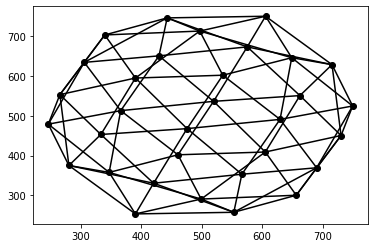

CPU times: user 32.2 s, sys: 149 ms, total: 32.4 s
Wall time: 32.6 s


In [2]:
%%time

class Args:
    file_name = "papa2.txt"
    iters = 10000
    showonlylast = True
    profile = False
    temp = 100
    limitrepulsion = False
    verbose = False

main(Args)